# Setup

In [41]:
LOG_PLOT = False

In [42]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import os
from helper import *
df = ecdc()
df_at = at()
def country_name(geoId):
    return df[df.geoId==geoId].iloc[0].countriesAndTerritories.replace('_', ' ')

print(df.columns)

Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')


## ECDC Data

In [43]:


def plot_selection(selection, roll_days=7, log=False):   
    f,ax = plt.subplots()
    ax.plot(selection.dateRep, selection['cases'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))

    plt.xticks(rotation=45)
    ax.bar(selection.dateRep, selection['cases'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    if log:
        plt.yscale('log')
        
    plt.title(selection.iloc[0].countriesAndTerritories.replace('_', ' '))
    plt.tight_layout()

    return f

def plot_comparison(geoIds, roll_days=7, log=False, ndays=30):
    f,ax = plt.subplots(figsize=(9,6))
    for geoId in geoIds:
        selection = select_country(geoId, ndays)
        ax.plot(selection.dateRep, selection['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'], 
                label=country_name(geoId))

    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.yaxis.set_major_locator(plt.MaxNLocator(10))

    plt.xticks(rotation=45)
    if log:
        plt.yscale('log')
        
    plt.legend(loc='best')
    plt.title('Cumulative number for 14 days of COVID-19 cases per 100000')
    plt.tight_layout()

def select_country(geoId, ndays=0):
    if not ndays:
        selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True)
    else:
        selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True).tail(ndays)
        
    return selection

def plot_country(geoId, **kwargs):
    return plot_selection(select_country(geoId), **kwargs)
    


## Austria - from Gesundheitsminesterium

In [44]:

def plot_Austria(roll_days=7, log=False):
    df = at()
    f,ax = plt.subplots()
    ax.plot(df.time, df['tägliche Erkrankungen'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(df.time, df['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    plt.title('Positive COVID tests')
    if log:
        plt.yscale('log')
    plt.tight_layout()
    return f


## DF Subsets

In [45]:
SELECTION =  df[df.geoId.isin(['AT', 'IN', 'US', 'UK', 'DE', 'IT', 'NL'])]
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


# Comparison per 100,000 of the population

<IPython.core.display.Javascript object>


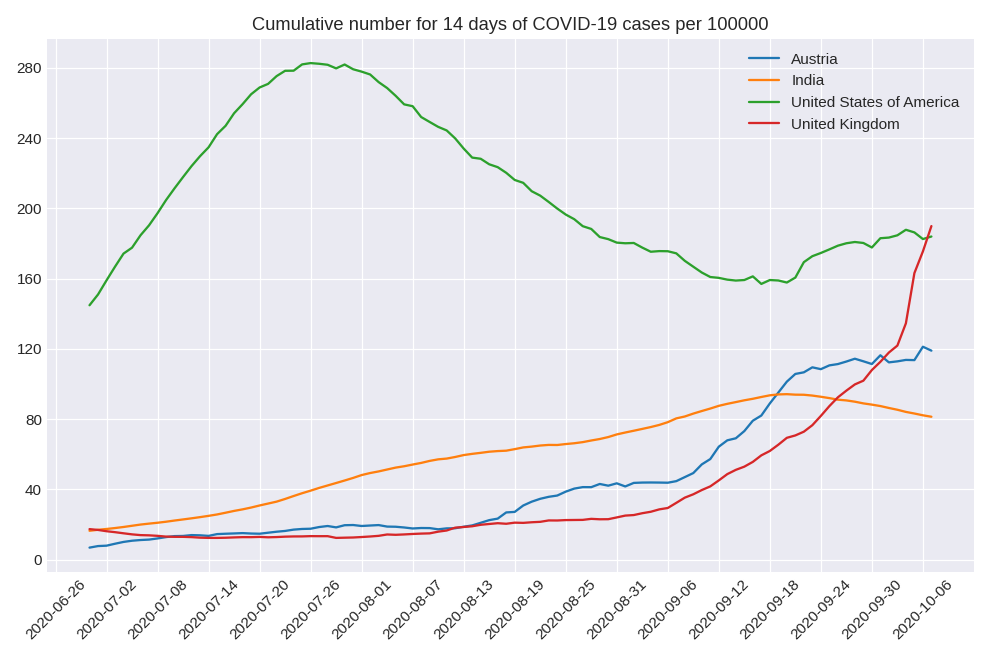

In [46]:
# countries = ['AT', 'IN', 'US', 'UK', 'DE', 'NL', 'FR',  'IT', 'ES','EL' ]
countries = ('AT', 'IN', 'US', 'UK')
plot_comparison(countries, log=False, ndays=100)


# Overview

## Selected Countries

In [47]:
overview(SELECTION, compact=False)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     6757131          531368       75910  72049  97894   
United_States_of_America  7501612          310551       44364  43062  78427   
United_Kingdom             530113           83957       11994  14542  22961   
Netherlands                144838           27418        3917   4517   4572   
Italy                      330263           17252        2465   2677   6557   
Germany                    306086           16867        2410   2828   6294   
Austria                     50435            5828         833    549   1268   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
India                     104555            7058        1008    986  2003   
United_States_of_America  210909            4911         702    717  4928   
United_Kingdom             42445             373          53     76  1224   
Netherlands                 6473              89          13     21   234   
Italy                      36030             155          22     28   971   
Germany                     9562              74          11     16   315   
Austria                      840              44           6     22    31   

                         Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  
                                                                             latest  
countriesAndTerritories                                                              
India                                                             81.316347          
United_States_of_America                                         183.957015          
United_Kingdom                                                   189.898701          
Netherlands                                                      270.197660          
Italy                                                             48.651791          
Germany                                                           36.327735          
Austria                                                          118.955499

## Most cases in the last 7 days

### Europe

In [48]:
overview(EU, compact=False).head(5)

cases                                            \
                             sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                      
France                    634763           84073       12010  10489  16972   
United_Kingdom            530113           83957       11994  14542  22961   
Russia                   1237504           69699        9957  11615  11656   
Spain                     825410           67238        9605  11998  31785   
Ukraine                   234584           29652        4236   4348   8702   

                        deaths                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
France                   32365             472          67     66  2004   
United_Kingdom           42445             373          53     76  1224   
Russia                   21663            1118         160    188   312   
Spain                    32486             872         125    261  1179   
Ukraine                   4520             455          65     90   129   

                        Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  
                                                                            latest  
countriesAndTerritories                                                             
France                                                          248.749185          
United_Kingdom                                                  189.898701          
Russia                                                           83.425046          
Spain                                                           304.967972          
Ukraine                                                         121.260701

### America

In [35]:
overview(AMERICA).head(5)

cases                                     deaths  \
                              sum last_7_days_sum rolling_avg latest     sum   
countriesAndTerritories                                                        
United_States_of_America  7458550          310506       44358  40705  210192   
Brazil                    4927235          181771       25967  11946  146675   
Argentina                  809715           86596       12371  11242   21468   
Colombia                   862158           43955        6279   7106   26844   
Mexico                     765082           31365        4481   3417   79268   

                                                             
                         last_7_days_sum rolling_avg latest  
countriesAndTerritories                                      
United_States_of_America            5122         732    398  
Brazil                              4617         660    323  
Argentina                           5355         765    450  
Colombia                            1203         172    132  
Mexico                              2665         381    180

### World

In [36]:
overview(df).head(5)

cases                                     deaths  \
                              sum last_7_days_sum rolling_avg latest     sum   
countriesAndTerritories                                                        
India                     6685082          539791       77113  61267  103569   
United_States_of_America  7458550          310506       44358  40705  210192   
Brazil                    4927235          181771       25967  11946  146675   
Argentina                  809715           86596       12371  11242   21468   
France                     624274           81635       11662   5104   32299   

                                                             
                         last_7_days_sum rolling_avg latest  
countriesAndTerritories                                      
India                               7251        1036    884  
United_States_of_America            5122         732    398  
Brazil                              4617         660    323  
Argentina                           5355         765    450  
France                               491          70     69

## Lowset number of new cases in the last 7 days

### Europe*

\*among countries with population of at least 1 million

In [58]:
overview(EU[EU.popData2019>1*10**7], compact=False).tail(5)

cases                                           \
                            sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                    
Belgium                  134197           12034        1719      0  3272   
Portugal                  80312            5595         799    427  1638   
Sweden                    96145            2992         427      0  1698   
Greece                    20541            2418         345    399   460   
Azerbaijan                40931             812         116    143   590   

                        deaths                                          \
                           sum last_7_days_sum rolling_avg latest  max   
countriesAndTerritories                                                  
Belgium                  10092              76          11      3  321   
Portugal                  2032              69          10     14   60   
Sweden                    5883               3           0      0  115   
Greece                     420              32           5      3    9   
Azerbaijan                 600              10           1      2   13   

                        Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  
                                                                            latest  
countriesAndTerritories                                                             
Belgium                                                         232.804817          
Portugal                                                        103.623595          
Sweden                                                           64.866862          
Greece                                                           43.013263          
Azerbaijan                                                       15.456244

### America*

\*among countries with population of at least 10 million

In [59]:
overview(AMERICA[AMERICA.popData2019>1*10**7]).tail(5)


cases                                    deaths  \
                            sum last_7_days_sum rolling_avg latest    sum   
countriesAndTerritories                                                     
Guatemala                 94870            3902         557    688   3310   
Dominican_Republic       115371            3471         496    317   2149   
Bolivia                  137468            2827         404    361   8156   
Cuba                       5883             352          50     38    123   
Haiti                      8838              91          13     19    229   

                                                            
                        last_7_days_sum rolling_avg latest  
countriesAndTerritories                                     
Guatemala                            72          10      8  
Dominican_Republic                   48           7      5  
Bolivia                             225          32     27  
Cuba                                  1           0      0  
Haiti                                 0           0      0

### World*
\*among countries with population of at least 10 million

In [60]:
overview( df[df.popData2019>1*10**7]).tail(5)


cases                                    deaths  \
                              sum last_7_days_sum rolling_avg latest    sum   
countriesAndTerritories                                                       
Taiwan                        521               7           1      3      7   
Niger                        1200               4           1      0     69   
Vietnam                      1098               4           1      1     35   
Cambodia                      280               3           0      0      0   
United_Republic_of_Tanzania   509               0           0      0     21   

                                                                
                            last_7_days_sum rolling_avg latest  
countriesAndTerritories                                         
Taiwan                                    0           0      0  
Niger                                     0           0      0  
Vietnam                                   0           0      0  
Cambodia                                  0           0      0  
United_Republic_of_Tanzania               0           0      0

# Austria
Compare ECDC data with Gesundheitsminesterium Data

## Plots

<IPython.core.display.Javascript object>


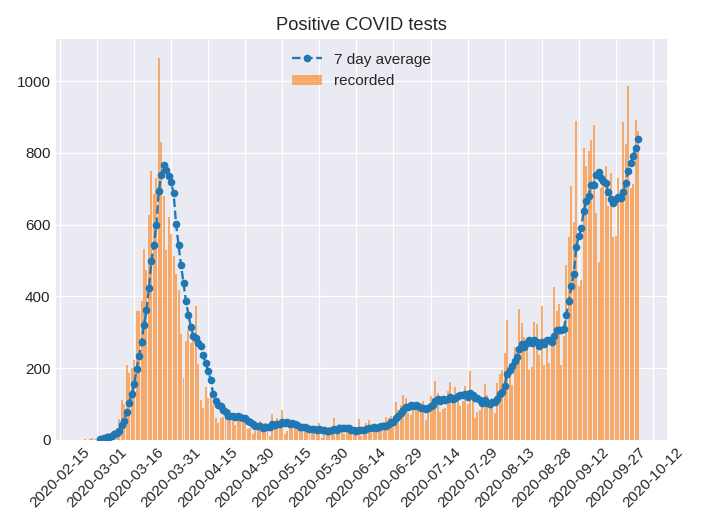

<IPython.core.display.Javascript object>


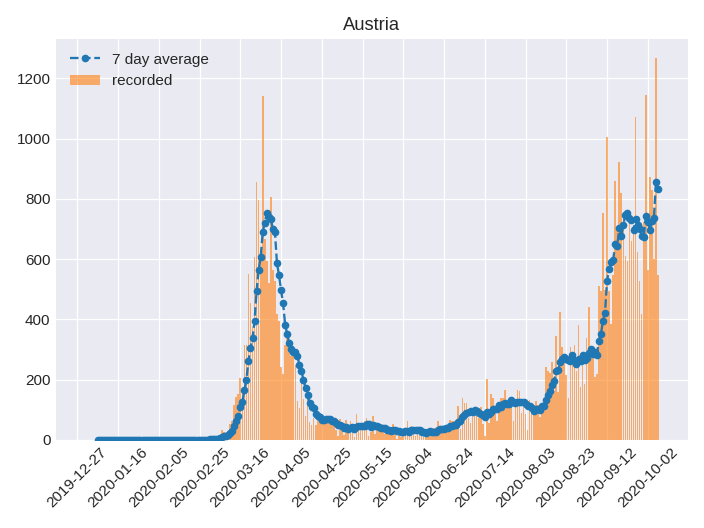

In [61]:
plot_Austria();
plot_country('AT', log=LOG_PLOT);

### Weekday bias

<IPython.core.display.Javascript object>


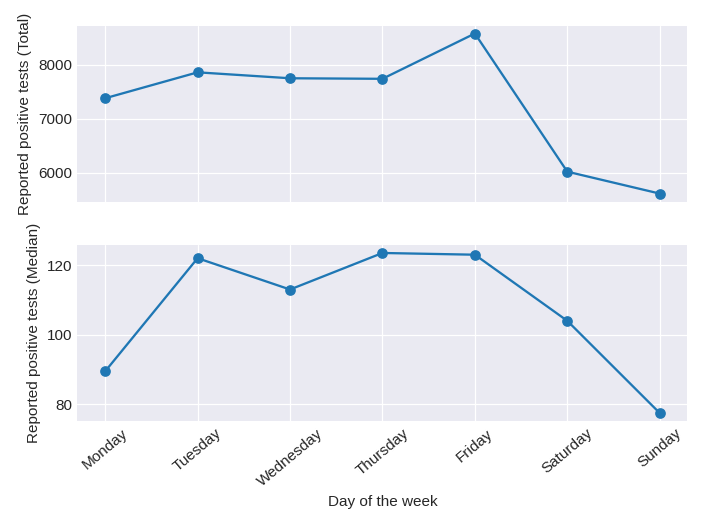

In [62]:
f, ax = plt.subplots(nrows=2, sharex=True)
df_at.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
df_at.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

# India

<IPython.core.display.Javascript object>


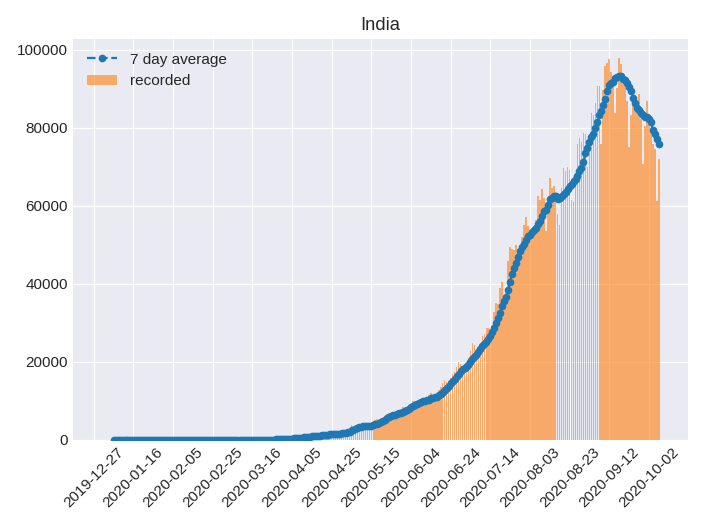

In [63]:
plot_country('IN', log=LOG_PLOT);

# USA

<IPython.core.display.Javascript object>


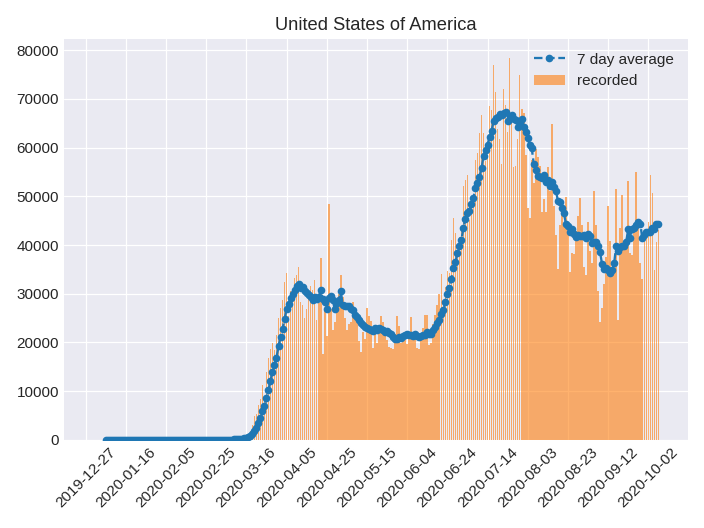

In [64]:
plot_country('US', log=LOG_PLOT);


# Germany

<IPython.core.display.Javascript object>


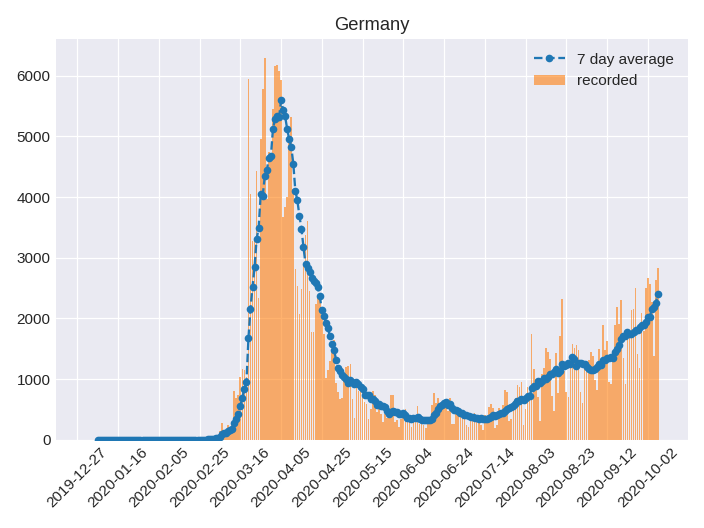

In [65]:
plot_country('DE', log=LOG_PLOT);

## UK

<IPython.core.display.Javascript object>


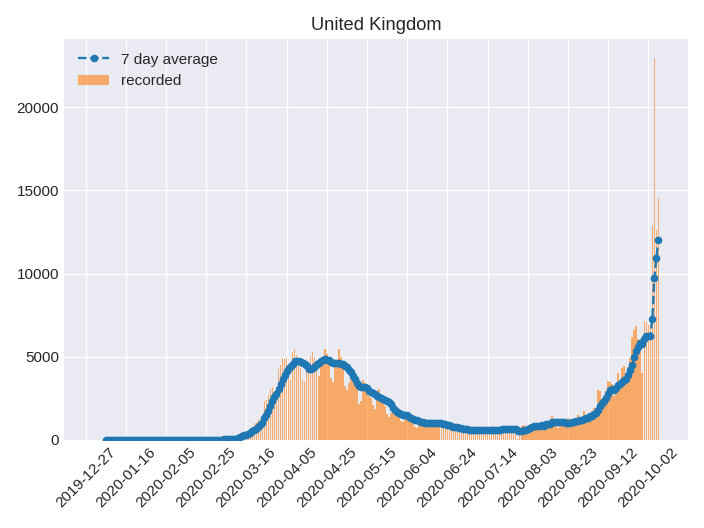

In [66]:
plot_country('UK', log=LOG_PLOT);

# China

<IPython.core.display.Javascript object>


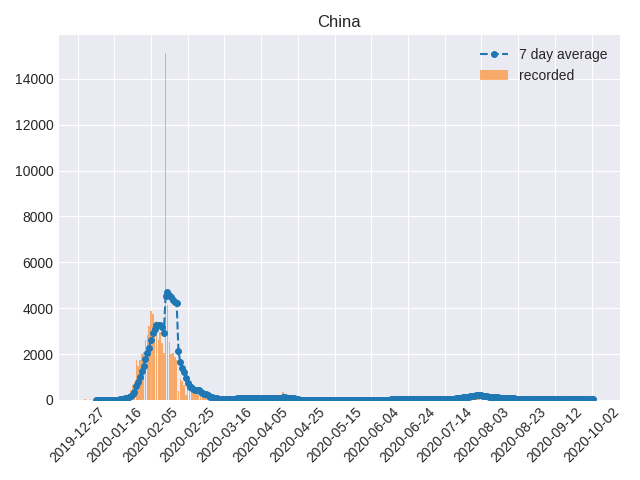

In [21]:
plot_country('CN', log=LOG_PLOT);


# Commit and Push

In [22]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[feature/angular 1e5b300] Last run on 2020-10-04 01:31
 5 files changed, 3611 insertions(+), 2684 deletions(-)
 rewrite notebooks/Austria_ECDC Data Differences.ipynb (60%)
 rewrite notebooks/__pycache__/helper.cpython-37.pyc (75%)
Enumerating objects: 19, done.
Counting objects: 100% (18/18), done.
Delta compression using up to 16 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (10/10), 464.88 KiB | 4.51 MiB/s, done.
Total 10 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 5 local objects.
To github.com:gythaogg/covid19.git
   cb95e47..1e5b300  feature/angular -> feature/angular


In [23]:
! git push --set-upstream origin feature/angular


Branch 'feature/angular' set up to track remote branch 'feature/angular' from 'origin'.
Everything up-to-date
